In [59]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

mnist_train = torchvision.datasets.MNIST(root="", train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root="", train=False, download=True, transform=torchvision.transforms.ToTensor())

In [3]:
# on colab, change runtime -> GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Fri Jun 25 07:52:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
EPOCH = 10
LR = 0.3
MOMENTUM = 0.9
batch_size = 256
num_workers = 0

mnist_train_iter = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
mnist_test_iter = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.cnn = nn.Sequential(nn.Conv2d(1, 24, 3, 1, 1),
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                             nn.Conv2d(24, 48, 3, 1, 1),
                             nn.ReLU(), 
                             nn.MaxPool2d(2))

    self.linear = nn.Sequential(nn.Flatten(), nn.Linear(2352, 64), nn.BatchNorm1d(64),
                                nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 10))
  def forward(self, x):
    x = self.cnn(x)
    x = self.linear(x)
    return x
model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), LR, MOMENTUM)

In [57]:
def num_correct(y_hat, y):
  correct_arr = y_hat.argmax(axis=1) == y
  return correct_arr.sum()

best_acc = 0
for e in range(EPOCH):
  model.train()

  total_loss = 0
  acc = 0
  for X, y in mnist_train_iter:
    X, y = X.to(device), y.to(device)
    y_hat = model(X)
    loss = criterion(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    acc += num_correct(y_hat, y)
  print("Training accuracy: {}, training loss: {} ".format(acc / len(mnist_train_iter.dataset),
                                                           total_loss / len(mnist_train_iter.dataset)))

  model.eval()
  test = 0
  with torch.no_grad():
    for X, y in mnist_test_iter:
      X, y = X.to(device), y.to(device)
      y_hat = model(X)

      test += num_correct(y_hat, y)
  acc = test / len(mnist_test_iter.dataset)
  print("Testing accuracy: {}".format(acc))

  if (acc > best_acc):
    torch.save(model, "saved_model")
    best_acc = acc
    print("saved")

Training accuracy: 0.9467166662216187, training loss: 0.0006903963724772136 
Testing accuracy: 0.98499995470047
saved
Training accuracy: 0.9793333411216736, training loss: 0.00026551415907839933 
Testing accuracy: 0.9865999817848206
saved
Training accuracy: 0.9838500022888184, training loss: 0.00020573906141022841 
Testing accuracy: 0.983299970626831
Training accuracy: 0.9860666990280151, training loss: 0.0001782986552764972 
Testing accuracy: 0.9896999597549438
saved
Training accuracy: 0.9898666739463806, training loss: 0.00012844264898837233 
Testing accuracy: 0.9861999750137329
Training accuracy: 0.9894500374794006, training loss: 0.00012935223076492548 
Testing accuracy: 0.9893999695777893
Training accuracy: 0.9916833639144897, training loss: 0.00010442972225137055 
Testing accuracy: 0.9893999695777893
Training accuracy: 0.9923333525657654, training loss: 9.560251724130164e-05 
Testing accuracy: 0.9916999936103821
saved
Training accuracy: 0.9929500222206116, training loss: 8.676296

# visualized input and output

Testing accuracy: 0.9934999942779541
2 1 0 4 1 4 9 5 
9 0 6 9 0 1 5 9 
7 3 4 9 6 6 5 4 
0 7 4 0 1 3 1 3 
4 7 2 7 1 2 1 1 
7 4 2 3 5 1 2 4 
4 6 3 5 5 6 0 4 
1 9 5 7 8 9 3 7 


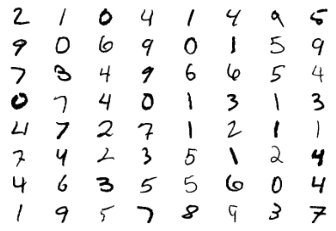

In [58]:
figure = plt.figure()
size = 8

saved_model = torch.load("saved_model").to(device)
saved_model.eval()

test = 0
with torch.no_grad():
  for X, y in mnist_test_iter:
    X, y = X.to(device), y.to(device)
    y_hat = saved_model(X)
    test += num_correct(y_hat, y)
acc = test / len(mnist_test_iter.dataset)
print("Testing accuracy: {}".format(acc))

with torch.no_grad():
  for index in range(1, size * size + 1):
    plt.subplot(size, size, index)
    plt.axis('off')
    plt.imshow(mnist_test[index][0].numpy().squeeze(), cmap='gray_r')

    t = mnist_test[index][0].to(device)
    t = t.unsqueeze(1)
    out = saved_model(t)
    prediction = out.argmax(dim=1, keepdim=True).cpu().numpy().item()
    print(prediction, end=" ")
    if index % size == 0:
      print("")

    if prediction != mnist_test[index][1]:
      print("{}th was wrong, predicted {} but was {}".format(index, prediction,
                                                            mnist_test[index][1]))
